## Differential Equations in a python application

This notebook is an example of how one could use differential equations in a python application.  The task is to predict weekly fantasy points for Julian Edelman (WR for the New England Patriots) in the 2019 season.  Therer are two hypothesis tested:

First, an ordinary differential equation that relates the recent slope of Edelman's performance provides a good tool to predict this week's performance.

Second, a partial differential equation that adds in the recent Fantasy performance of the quarterback is tested.

It is important to note that there are many factors that contribute to FP performance, and an actual model would include many more independent variables.  However, one of challenges that fantasy players face is recency bias.  This excercise will provide a an easy to understand tool to discuss those beliefs in laymen's terms (a more formal discussion would involve probability tests on distributions, but most normal people understand simple equations better.) 

FP is calculated as standard PPR fp and good explainations are available all over the internet.  Data is constrained to 2019, and multiple simplifications are made (ie: bye weeks are removed and ignored.)

### Basic Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sympy.interactive import printing
printing.init_printing(use_latex=True)

from sympy import *
from sympy.functions.elementary.exponential import log as splog
import sympy as sp

from scipy.optimize import curve_fit

### Data Initialization

In [2]:
je_fp=[13.4, 7.20, 15.7, 5.0, 21.0, 15.8, 10.2, 23.5, 11.9, 12.4, 13.3]  # Edelman FP calculated elsewhere
tb_fp=[25.6, 24.7, 20.1, 4.7, 25.0, 23.0, 13.0, 18.4, 14.4, 8.5, 11.3]  # Brady FP calculated elsewhere

### Ordinary DiffEq Example

As an example of how an ordinary diffeq might be used in python, let's examine the assumption that Edelman's fantasy points are described by a function: last_week_fp + some_constant(n) * the slope of the weekly change in Julian's fantasy points (again, this is an large simplification).  This equation is coded below

Julian's diffeq


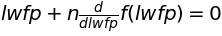

In [3]:
x=sp.Symbol('lwfp')
fp=sp.Function('f')(x)
f=sp.Function('f')(x)
n=sp.Symbol('n')
diffeq=Eq(x+n*f.diff(x))
print("Julian's diffeq")
display(diffeq)

In [4]:
print("This week's predicted fantasy points based on the ordinary diffeq would be:")
dsolve(diffeq,fp)

This week's predicted fantasy points based on the ordinary diffeq would be:


### Using the Equation

Once we have solved the diffeq, we could use it to predict Julian's performance next week.  To do that, we rewrite the function in numpy friendly form and use scipy.curvefit.

Best values:  C1= 13.6 n= 17118255.7
Julian last week fp: [13.4, 7.2, 15.7, 5.0, 21.0, 15.8, 10.2, 23.5, 11.9]
Julian predictions for this week fp: [13.6, 13.6, 13.6, 13.6, 13.6, 13.6, 13.6, 13.6, 13.6] 




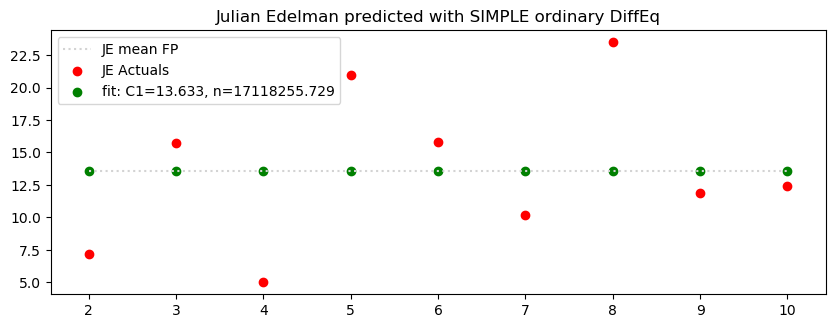

In [5]:

def twfp(x,C1,n):
    return C1-(0-x)/float(2*n)

    
fit_params, pcov = curve_fit(twfp, je_fp[:-2],je_fp[1:-1])
print('Best values:  C1= {:4.1f} n= {:4.1f}'.format(fit_params[0],fit_params[1]))

preds=[round(twfp(x,fit_params[0],fit_params[1]),1) for x in je_fp[:-2]]
print('Julian last week fp:',je_fp[:-2])
print('Julian predictions for this week fp:',preds,'\n\n')


plt.figure(figsize=(10,3.5),dpi=100)
plt.scatter(range(2,len(je_fp)), je_fp[1:-1], color='r',label='JE Actuals')
plt.scatter(range(2,len(je_fp)), preds, color='g',label='fit: C1={:5.3f}, n={:5.3f}'.format(fit_params[0],fit_params[1]))
plt.plot(range(2,len(je_fp)),[np.mean(je_fp) for x in range(2,len(je_fp))],'lightgrey',lineStyle=':',label='JE mean FP')
plt.legend(loc='best')
plt.title('Julian Edelman predicted with SIMPLE ordinary DiffEq')
plt.show()

### Note:

Similarity of overall mean and equation predicted value discussed below.

### Partial DiffEq Example

As an example of how partial diffeq might be used in python, let's examine the assumption that Edelman's fantasy points are also impacted by Tom Brady's recent perfomance, that the shape of the impact would be similar but the coeeficients may differ.  This new model could be described by described by the following function:  

function: last_week_fp + some_constant(n) * the slope of the weekly change in Julian's fantasy points __+ some_constant(m) * the slope of the weekly change in Brady's fantasy points__ (again, this is a completely made up equation).  

Julian's diffeq


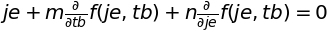

In [6]:
je=sp.Symbol('je')
tb=sp.Symbol('tb')
fp=sp.Function('f')(je,tb)
n=sp.Symbol('n')
m=sp.Symbol('m')
diffeq=Eq(je+n*fp.diff(je)+m*fp.diff(tb))
print("Julian's diffeq")
display(diffeq)

This week's predicted fantasy points would be:


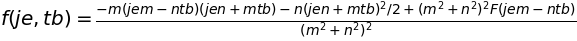

In [7]:
print("This week's predicted fantasy points would be:")
pdsolve(diffeq,fp)

In [8]:

def twfp_wtb(week,n,m):
    '''
    je_fp = julian fantasy points
    week=index week
    n='''
    
    w=np.int(week)
    a=(0-m)*(je_fp[w-1]*m-tb_fp[w-1]*n)*(je_fp[w-1]*n+tb_fp[w-1]*m)
    b=n*((je_fp[w-1]*n+tb_fp[w-1]*m)**2)/2
    c=((m**2+n**2)**2)*(je_fp[w-1]*m-tb_fp[w-1]*n)

    fp=(a-b+c)/(m**2+n**2)
    return fp
    

In [9]:
#  Simple solver

res=[]
for n in range(1,100):
    for m in range(1,100):
        tmp=0
        error=[]
        for week in range(1,len(je_fp)):
            fp=twfp_wtb(week,n/10,m/10)
            error.append((je_fp[week]-fp)**2)
        error=np.sqrt(np.mean(error))
        res.append([n,m,round(float(n)/10,1),round(float(m)/10,1),error])

results=pd.DataFrame(columns=['n_ind','m_ind','n','m','error'],data=res)
res=results.sort_values('error',ascending=True).reset_index(drop=True)
res.head(1)
            

,n_ind,m_ind,n,m,error
0,1,1,0.1,0.1,37.122336


Julian last week fp: [13.4, 7.2, 15.7, 5.0, 21.0, 15.8, 10.2, 23.5, 11.9]
Julian predictions for this week fp: [13.6, 13.6, 13.6, 13.6, 13.6, 13.6, 13.6, 13.6, 13.6] 




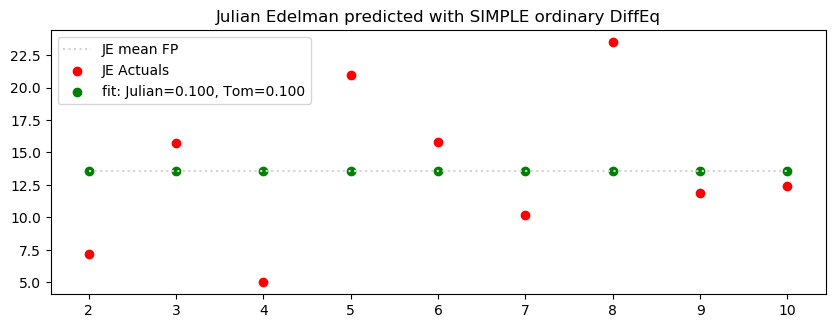

In [10]:
tb_preds=[round(twfp_wtb(w,res['n'][0],res['m'][0]),1) for w in range(1,len(je_fp))]
print('Julian last week fp:',je_fp[:-2])
print('Julian predictions for this week fp:',preds,'\n\n')

plt.figure(figsize=(10,3.5),dpi=100)
plt.scatter(range(2,len(je_fp)), je_fp[1:-1], color='r',label='JE Actuals')
plt.scatter(range(2,len(je_fp)), preds, color='g',label='fit: Julian={:5.3f}, Tom={:5.3f}'.format(res['n'][0],res['m'][0]))
plt.plot(range(2,len(je_fp)),[np.mean(je_fp) for x in range(2,len(je_fp))],'lightgrey',lineStyle=':',label='JE mean FP')
plt.legend(loc='best')
plt.title('Julian Edelman predicted with SIMPLE ordinary DiffEq')
plt.show()

## Summary

In this example, neither the ordinary differential equation, nor the partial differential equation approach yielded very good results.  In the first case (using an ordinary differential equation), the slope of Edelman's fantasy performance essentially had no impact, and the derived constant was roughly equal to the mean of Edelman's performance.

In the second case, addition of another variable (creating a partial differential equation), namely the previous week's Fantasy performance of the quarterback (Brady) provided roughly the same answer: namely it calculated each week's prediction as the Edelman's average FP performance and minimized the coefficients on the differential terms.  This solution also approaches Edleman's year long FP performance.

At first glance, this is a little non-intuitive, but upon further thought, it makes perfect sense.  First, and most simply, consder the 2019 Patriots experience.  Aside from Julian Edelman, there has been no consistency among the Patriots' receivers.  Consequently, Edelman's performance is really dependant on his interaction with Brady alone, and is not impacted by how Tom does with the other receivers, which dictates Tom's fantasy performance.

Equally important, I know from other work (see report on WR prediction) that previous weekly performance for an individual player is very loosley correlated with this week's performance.  In a RandomForest based model, the most important feature was average FP performance over a longer time period.
